# Reflectivity analysis code

### Analyzes and plots data from pump-probe reflectivity experiments. Currently, these experiments have involved identical pump and probe pulses (5 - 100 fs), differing only by intensity and polarization. The input data includes measurements of the incident pump energy and the probe reflectivity for each delay. For later data sets, an additional "offset" measurement at each delay, where the delay stage was set to some fixed negative delay. This was done to correct for a drift that appeared in the data over the course of ~1 hour.

In [1]:
#Imports
from math import *
import cmath
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import glob
import re

#Import custom modules
from physics import *

sns.set(font_scale=1.5)
sns.set_style("ticks")
sns.set_palette(palette='deep')
sns.set_color_codes(palette='deep')
mpl.rcParams.update({'font.family': 'serif', 'font.serif':'DejaVu Serif'})

%matplotlib notebook

/home/drake/.anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Load all data

## Create list of file names for positive and negative delays

In [2]:
Directory = os.curdir + r'/Reflectivity_Data/GaAs_09_21/run2/run2_scan'

DelayPath = Directory + '/pos_*[!Offset]'
OffsetPath = Directory + '/pos_*Offset'

#Load in all of the filenames, sorted according to the digits at the end
DelayFilenames = sorted(glob.glob(DelayPath),key=lambda x: int(re.findall(r'_(\d*?)\Z',x)[0]))
OffsetFilenames = sorted(glob.glob(OffsetPath),key=lambda x: int(re.findall(r'_(\d*?)Offset',x)[0]))

#Load in boxcar offsets
BoxcarOffsetBeforeFilename = os.curdir + r'/Reflectivity_Data/GaAs_09_21/run2/run2_blocked_BeforeScan'
BoxcarOffsetAfterFilename = os.curdir + r'/Reflectivity_Data/GaAs_09_21/run2/run2_blocked_AfterScan'

## Read files and create arrays for signals

In [3]:
BoxcarOffsetBefore = np.mean(pd.read_csv(BoxcarOffsetBeforeFilename, delimiter=",").values,axis=0)
BoxcarOffsetAfter = np.mean(pd.read_csv(BoxcarOffsetAfterFilename, delimiter=",").values,axis=0)
BoxcarOffset = (BoxcarOffsetBefore + BoxcarOffsetAfter)/2

binsize = 0.01 #Size of bins (Volts)
minbin = 0.45
maxbin = 0.55
bins = np.arange(minbin,maxbin+binsize,binsize)

BinnedProbeVoltage = np.zeros((len(DelayFilenames),len(bins)))
MeanProbeVoltage = np.zeros(len(DelayFilenames))
MeanPumpVoltage = np.zeros(len(DelayFilenames))
MeanOfRatios = np.zeros(len(DelayFilenames))
Delay = np.zeros(len(DelayFilenames))

for i,filename in enumerate(DelayFilenames):
    Delay[i] = (float(filename[(len(Directory)+5):(len(Directory)+13)])-10.6)*-2/0.3 #ps of delay
        
    Data = pd.read_csv(filename, delimiter=",").values - BoxcarOffset
    MeanPumpVoltage[i] = np.mean(Data[:,1],axis=0) #Input is inverted
    MeanProbeVoltage[i] = np.mean(Data[:,0],axis=0)
    MeanOfRatios[i] = np.sum(Data[:,0]/Data[:,1])/len(Data[:,1])
    
    #Energy binning:
    BinnedPumpVoltage = np.digitize(Data[:,1],bins)
    for j in range(len(bins)):
        indices = np.where(BinnedPumpVoltage==j)
        BinnedProbeVoltage[i,j] = np.mean(Data[indices,0]/Data[indices,1])

RatioOfMeans = MeanProbeVoltage/MeanPumpVoltage

#Repeat for the offsets
OffsetBinnedProbeVoltage = np.zeros((len(OffsetFilenames),len(bins)))
OffsetMeanProbeVoltage = np.zeros(len(OffsetFilenames))
OffsetMeanPumpVoltage = np.zeros(len(OffsetFilenames))
OffsetMeanOfRatios = np.zeros(len(OffsetFilenames))
OffsetDelay = np.zeros(len(OffsetFilenames))

for i,filename in enumerate(OffsetFilenames):
    OffsetDelay[i] = (float(filename[(len(Directory)+5):(len(Directory)+13)])-10.6)*2/0.3 #ps of delay
    
    Data = pd.read_csv(filename, delimiter=",").values - BoxcarOffset
    OffsetMeanPumpVoltage[i] = np.mean(Data[:,1],axis=0) #Input is inverted
    OffsetMeanProbeVoltage[i] = np.mean(Data[:,0],axis=0)
    OffsetMeanOfRatios[i] = np.sum(Data[:,0]/Data[:,1])/len(Data[:,1])
    
    #Energy binning:
    OffsetBinnedPumpVoltage = np.digitize(Data[:,1],bins)
    for j in range(len(bins)):
        indices = np.where(OffsetBinnedPumpVoltage==j)[0]
        OffsetBinnedProbeVoltage[i,j] = np.mean(Data[indices,0]/Data[indices,1])
    
OffsetRatioOfMeans = OffsetMeanProbeVoltage/OffsetMeanPumpVoltage

/home/drake/.anaconda3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


## <strike> Apply calibration so that $R_0$ (unexcited) is the appropriate value </strike>

In [565]:
# R0 = 0.45560 #Silicon at 760nm wavelength, s-polarized at 45 degrees

# #Conversion factor between reflectivity using incident pump voltage to reflectivity using incident probe voltage
# IncidentPumptoProbeCalibration = R0/np.mean(OffsetRatioOfMeans)

# MeanOfRatios *= IncidentPumptoProbeCalibration
# RatioOfMeans *= IncidentPumptoProbeCalibration
# OffsetMeanOfRatios *= IncidentPumptoProbeCalibration
# OffsetRatioOfMeans *= IncidentPumptoProbeCalibration
# BinnedProbeVoltage *= IncidentPumptoProbeCalibration
# OffsetBinnedProbeVoltage *= IncidentPumptoProbeCalibration

## Average data immediately before pump pulse to determine $R_0$

In [4]:
#This could be done more elegantly

#Find indices that most closely match the desired range
BeforePumpDelayRange = np.array([-5,0])
BeforePumpDelayIndexmin = min(range(len(Delay)),key=lambda i: abs(Delay[i]-BeforePumpDelayRange[0]))
BeforePumpDelayIndexmax = min(range(len(Delay)),key=lambda i: abs(Delay[i]-BeforePumpDelayRange[1]))
BeforePumpDelayRange = np.array([Delay[BeforePumpDelayIndexmin],Delay[BeforePumpDelayIndexmax]]) #Closest matching values

R0measured = np.nanmedian(BinnedProbeVoltage[BeforePumpDelayIndexmin:BeforePumpDelayIndexmax,:],axis=0)
R0 = np.nanmedian(R0measured)
R0err = np.nanstd(R0measured)
print(R0,R0err)

0.337663626611 0.00535701727721


/home/drake/.anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:740: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


## Subtract each delay by its associated offset

In [5]:
MeanProbeVoltage = MeanProbeVoltage-OffsetMeanProbeVoltage
MeanPumpVoltage = MeanPumpVoltage-OffsetMeanPumpVoltage
MeanOfRatios = MeanOfRatios-OffsetMeanOfRatios
RatioOfMeans = RatioOfMeans-OffsetRatioOfMeans
BinnedProbeVoltageDiff = BinnedProbeVoltage - OffsetBinnedProbeVoltage

#Mask the NaNs and ignore the first bin
#BinnedProbeVoltageMasked = np.ma.masked_where(np.isnan(BinnedProbeVoltageDiff),BinnedProbeVoltageDiff)[:,1:]

## Average data immediately after pump pulse to determine $\Delta R$ due to ionization

In [6]:
#This could be done more elegantly

#Find indices that most closely match the desired range
AfterPumpDelayRange = np.array([5,20])
AfterPumpDelayIndexmin = min(range(len(Delay)),key=lambda i: abs(Delay[i]-AfterPumpDelayRange[0]))
AfterPumpDelayIndexmax = min(range(len(Delay)),key=lambda i: abs(Delay[i]-AfterPumpDelayRange[1]))
AfterPumpDelayRange = np.array([Delay[AfterPumpDelayIndexmin],Delay[AfterPumpDelayIndexmax]]) #Closest matching values

DeltaRmeasured = np.nanmedian(BinnedProbeVoltageDiff[AfterPumpDelayIndexmin:AfterPumpDelayIndexmax,:],axis=0)
print(DeltaRmeasured)

[        nan -0.00108927 -0.00183958 -0.0017901  -0.00245357 -0.00212769
 -0.00201012 -0.00209228 -0.00078085         nan         nan         nan]


/home/drake/.anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:740: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


## Convert pump voltage into fluence

In [7]:
#Fake calibration
CalibrationSlope = 1.0
Calibration_yIntercept = 0

SpotSizeFWHM = sqrt(1/pi*200*log(2)) #FWHM focal spot size in um
w0 = SpotSizeFWHM/sqrt(2*log(2)) #Beam waist radius in um
PulseDuration = 1

MeanPumpEnergy = MeanPumpVoltage*CalibrationSlope + Calibration_yIntercept
PumpEnergy = bins*CalibrationSlope + Calibration_yIntercept #in uJ
PumpFluence = PumpEnergy/(pi*w0**2)*100 #Average (not peak) fluence in J/cm^2
PumpIntensity = PumpFluence/1 #W/cm^2

#Real calibration
# CalibrationSlope = 1.0/np.mean(-OffsetMeanPumpVoltage)
# Calibration_yIntercept = 0

# SpotSizeFWHM = 70.0 #FWHM focal spot size in um
# w0 = SpotSizeFWHM/sqrt(2*log(2)) #Beam waist radius in um
# PulseDuration = 100.0 #fs

# MeanPumpEnergy = MeanPumpVoltage*CalibrationSlope + Calibration_yIntercept
# PumpEnergy = bins*CalibrationSlope + Calibration_yIntercept #in uJ
# PumpFluence = 2*PumpEnergy/(pi*w0**2)*100 #Peak fluence in J/cm^2
# PumpIntensity = PumpFluence/PulseDuration*10**3 #W/cm^2

# Calculate $\Delta n$ from change in reflectivity

## Define functions for Drude model and Fresnel reflection

In [8]:
def omegap(ne):
    """Plasma frequency (ne in cm^-3)"""
    return np.sqrt((ne*10**6)*q**2/(meff*epsilon0))

def epsilonPrime(ne,tau):
    """Real part of dielectric constant (tau in fs, ne in cm^-3)"""
    return epsilonc - omegap(ne)**2/(omega**2+1/(tau*10**-15)**2)

def epsilonDoublePrime(ne,tau):
    """Imaginary part of dielectric constant (tau in fs, ne in cm^-3)"""
    return omegap(ne)**2/((tau*10**-15)*omega*(omega**2+1/(tau*10**-15)**2))

def RefractiveIndex(ne,tau):
    """Complex refractive index (tau in fs, ne in cm^-3)"""
    return np.sqrt(epsilonPrime(ne,tau) + 1.0j*epsilonDoublePrime(ne,tau))

def Reflectivity_spol(n,theta):
    """Calculates a material's reflectivity (in vacuum) for s-polarized light given the angle of 
    incidence theta (degrees) and the complex refractive index n."""
    theta *= 2*pi/360
    return np.abs((cos(theta) - np.sqrt(n**2 - (sin(theta))**2))/(cos(theta) + np.sqrt(n**2 - (sin(theta))**2)))**2

## Calculate reflectivity as a function of $n_e$

In [9]:
tau = 47.0 #fs
meff = 0.203577*me
ne = np.logspace(18,20,10000)

theta = 45
wavelength = 760.0*10**-9 #Laser wavelength in m
omega = 2*pi*c/wavelength #Laser frequency

#non-excited refractive index (from refractiveindex.info, units in um)
wavelength_um = wavelength*10**6
#n0 = sqrt(9.28156 + 6.72880*wavelength_um**2/(wavelength_um**2-0.44105) + 0.21307*wavelength_um**2/(wavelength_um**2-3870.1)) #Ge
n0 = 3.7030 #GaAs at 760 nm
#n0 = 3.7264 #Si at 760 nm
epsilonc = n0**2

n = RefractiveIndex(ne,tau)
R = Reflectivity_spol(n0,theta)
DeltaR = Reflectivity_spol(n,theta) - R

## Match the observed $\Delta R$ to the corresponding $n_e$

In [10]:
DeltaRindex = np.zeros(len(DeltaRmeasured))
ElectronDensity = np.zeros(len(DeltaRmeasured))
for idx in range(len(DeltaRmeasured)):
    DeltaRindex[idx] = min(range(len(DeltaR)),key=lambda i: abs(DeltaR[i]-DeltaRmeasured[idx]))
    ElectronDensity[idx] = ne[DeltaRindex[idx]]
    print('At ne =',ElectronDensity[idx],'cm^-3, DeltaR =',DeltaR[DeltaRindex[idx]])
    
print(np.mean(ElectronDensity[1:-3]), np.std(ElectronDensity[0:-3]))

At ne = 1e+18 cm^-3, DeltaR = -3.541488327e-05
At ne = 3.06583413162e+19 cm^-3, DeltaR = -0.00108929464465
At ne = 5.16620121396e+19 cm^-3, DeltaR = -0.001839801203
At ne = 5.02770904525e+19 cm^-3, DeltaR = -0.00179020801648
At ne = 6.87675795282e+19 cm^-3, DeltaR = -0.00245359194967
At ne = 5.97004490468e+19 cm^-3, DeltaR = -0.00212795189606
At ne = 5.64124728502e+19 cm^-3, DeltaR = -0.00201002734929
At ne = 5.8718760263e+19 cm^-3, DeltaR = -0.00209273428601
At ne = 2.19955199876e+19 cm^-3, DeltaR = -0.000780761182865
At ne = 1e+18 cm^-3, DeltaR = -3.541488327e-05
At ne = 1e+18 cm^-3, DeltaR = -3.541488327e-05
At ne = 1e+18 cm^-3, DeltaR = -3.541488327e-05
4.9774028198e+19 2.06527413233e+19


/home/drake/.anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/drake/.anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


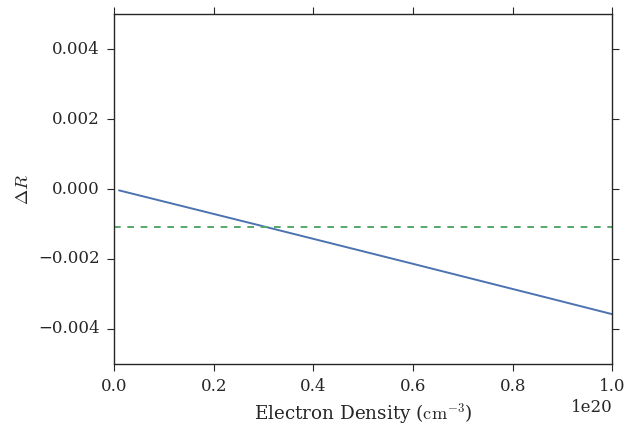

/home/drake/.anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [15]:
plt.figure()
plt.plot(ne,DeltaR)
plt.axhline(DeltaR[DeltaRindex[1]],linestyle='--',color='g')
plt.ylabel('$\Delta R$')
plt.xlabel('Electron Density ($\mathrm{cm^{-3}}$)')
plt.ylim(-0.005,0.005)
plt.tight_layout()

# Plot data

## Select a particular bin and delay for creating lineouts

In [16]:
SelectPumpIntensity = 0.51 #Desired pump fluence at which a lineout is taken (J/cm^2)
SelectDelay = 10 #Desired delay at which a lineout is taken (ps)

#Find index at which the array values are closest to the desired lineout value
SelectPumpIntensityIndex = min(range(len(PumpIntensity)),key=lambda i: abs(PumpIntensity[i]-SelectPumpIntensity))
SelectDelayIndex = min(range(len(Delay)),key=lambda i: abs(Delay[i]-SelectDelay))

#Closest matching values
SelectPumpIntensity = PumpIntensity[SelectPumpIntensityIndex]
SelectDelay = Delay[SelectDelayIndex]

## Contour plot with lineouts

In [17]:
Connect_Points = True #Choose whether or not to connect the data points with lines

if Connect_Points is True:
    linestyle = '-'
else:
    linestyle = 'None'

In [18]:
#Reorder arrays
NormalizedProbeVoltage_vs_Delay_type = np.dtype([('Delay',Delay.dtype),\
                                       ('Probe Voltage',BinnedProbeVoltageDiff[:,SelectPumpIntensityIndex].dtype)])
NormalizedProbeVoltage_vs_Delay=np.empty(len(Delay),dtype=NormalizedProbeVoltage_vs_Delay_type)
NormalizedProbeVoltage_vs_Delay['Delay'] = Delay
NormalizedProbeVoltage_vs_Delay['Probe Voltage'] = BinnedProbeVoltageDiff[:,SelectPumpIntensityIndex]/R0
NormalizedProbeVoltage_vs_Delay = np.sort(NormalizedProbeVoltage_vs_Delay, order='Delay')

<IPython.core.display.Javascript object>


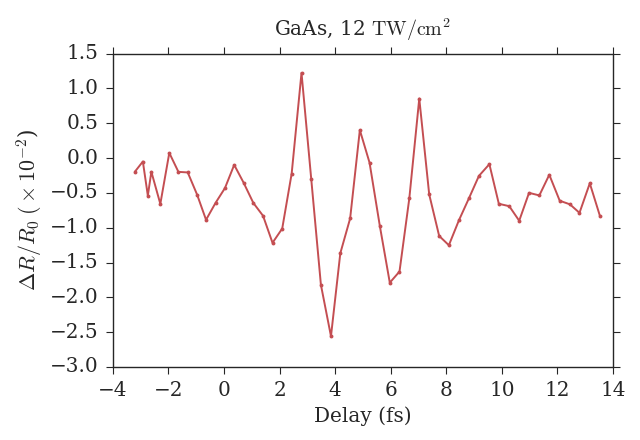

In [19]:
plt.figure()
plt.plot(NormalizedProbeVoltage_vs_Delay['Delay'],NormalizedProbeVoltage_vs_Delay['Probe Voltage']*10**2,\
         linestyle=linestyle,marker='.',color='r')

#plt.xlim(np.min(Delay),np.max(Delay))
fontsize = 18
plt.xlabel('Delay (fs)',fontsize=fontsize)
plt.ylabel('$\Delta R /R_0 \: (\\times 10^{-2}$)',fontsize=fontsize*1.1)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
#plt.xlim(-10)
#plt.ylim(-25,15)
plt.title('GaAs, 12 $\mathrm{TW/cm^2}$',fontsize=fontsize,y=1.04)
plt.tight_layout()
plt.savefig('GaAs.svg')

<IPython.core.display.Javascript object>


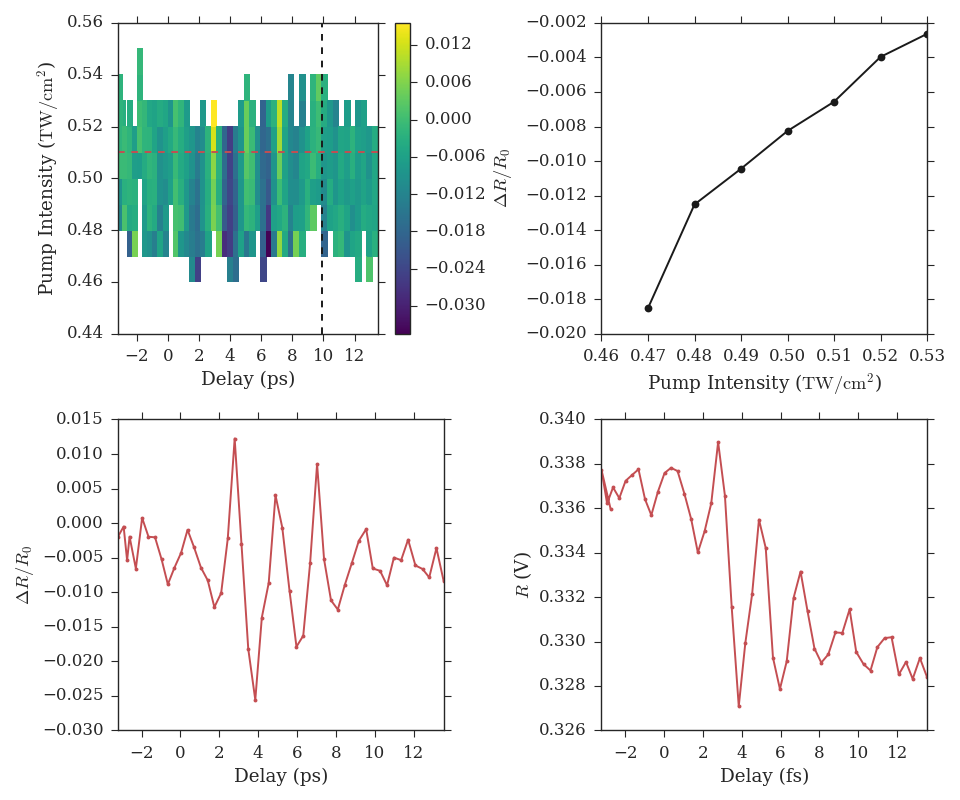

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,10))

#Range of delays to plot
minDelay = np.min(Delay)
maxDelay = np.max(Delay)

#Create arrays necessary for mesh plot (2D arrays for energy and delay, masked array for probe signal)
BinnedProbeVoltageMasked = np.ma.masked_where(np.isnan(BinnedProbeVoltageDiff),BinnedProbeVoltageDiff)[:,1:] #Mask the NaNs and ignore the first bin
EnergyGrid,DelayGrid = np.meshgrid(PumpIntensity[1:],Delay) #Ignore the first bin

#Contour plot of reflectance
mesh = ax1.pcolormesh(DelayGrid, EnergyGrid, BinnedProbeVoltageMasked/R0,cmap='viridis')
ax1.axvline(SelectDelay,linestyle='--',color='k')
ax1.axhline(SelectPumpIntensity,linestyle='--',color='r')
ax1.set_xlim(minDelay,maxDelay)
ax1.set_xlabel('Delay (ps)')
ax1.set_ylabel('Pump Intensity ($\mathrm{TW/cm^2}$)')
#mesh.set_clim(0,0.1)
plt.colorbar(mesh,ax=ax1,label='$\Delta R /R_0$')

#Lineout across constant delay
ax2.plot(EnergyGrid[0,:],BinnedProbeVoltageMasked[SelectDelayIndex,:]/R0,linestyle=linestyle,marker='o',color='k')
ax2.set_xlabel('Pump Intensity ($\mathrm{TW/cm^2}$)')

#Lineout across constant pump fluence
ax3.plot(NormalizedProbeVoltage_vs_Delay['Delay'],NormalizedProbeVoltage_vs_Delay['Probe Voltage'],linestyle=linestyle,marker='.',color='r')
ax3.set_xlim(np.min(Delay),np.max(Delay))
ax3.set_xlabel('Delay (ps)')
ax3.set_ylabel('$\Delta R /R_0$')

#Absolute probe reflectivity
ax4.plot(Delay,BinnedProbeVoltage[:,SelectPumpIntensityIndex],linestyle=linestyle,marker='.',color='r')
ax4.set_xlim(np.min(Delay),np.max(Delay))
ax4.set_xlabel('Delay (fs)')
ax4.set_ylabel('$R$ (V)')

plt.tight_layout()
#plt.savefig('Reflectivity_Plot_Highest_Energy_Short_Delay.png')

## Plot of average ratios, reflectance signals, and input signals

<IPython.core.display.Javascript object>


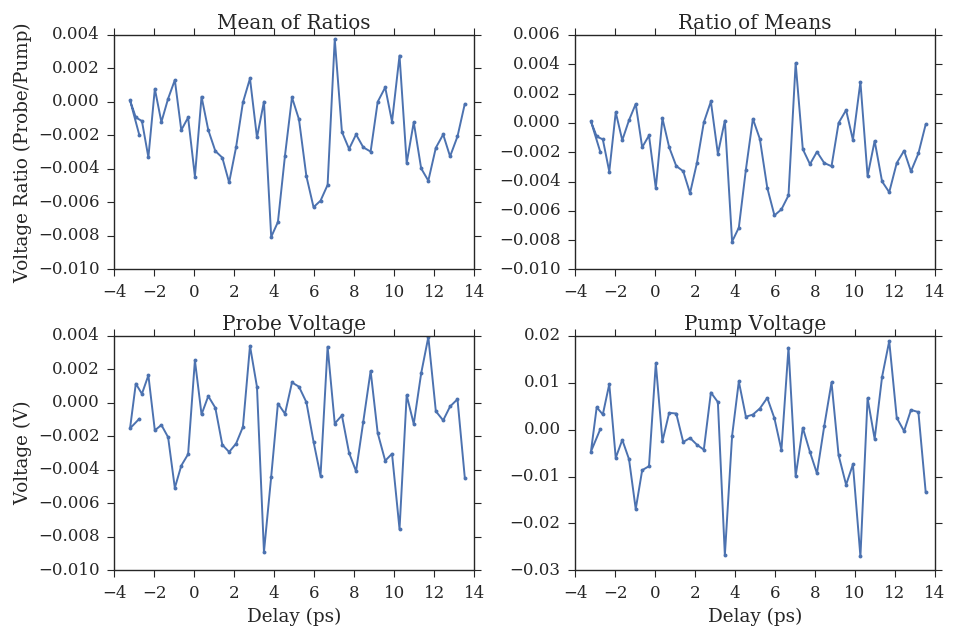

/home/drake/.anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [21]:
fig2 = plt.figure(figsize=(12,8))
plt.subplot(221)
plt.plot(Delay,MeanOfRatios,linestyle=linestyle,marker='.',label='Ratio')
plt.title('Mean of Ratios')
plt.ylabel('Voltage Ratio (Probe/Pump)')

plt.subplot(222)
plt.plot(Delay,RatioOfMeans,linestyle=linestyle,marker='.')
plt.title('Ratio of Means')

plt.subplot(223)
plt.plot(Delay,MeanProbeVoltage,linestyle=linestyle,marker='.')
plt.title('Probe Voltage')
plt.xlabel('Delay (ps)')
plt.ylabel('Voltage (V)')

plt.subplot(224)
plt.plot(Delay,MeanPumpVoltage,linestyle=linestyle,marker='.')
plt.title('Pump Voltage')
plt.xlabel('Delay (ps)')

#plt.xlim(-2.0,2.0)
plt.legend(frameon=True)
plt.tight_layout()
plt.show()